# Install Packages

In this approach data is segmented and feature are calculated for each segment. Then these features are averaged

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
!pip install wfdb
!pip install mne
!pip install nitime
!pip install nolds

In [3]:
!pip install git+https://github.com/forrestbao/pyeeg.git
!pip install git+https://github.com/raphaelvallat/entropy.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-y6jdxote
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-y6jdxote
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28121 sha256=33064cf6c545234a685fd29e1fcf3b28cb82e25dd9e10b0cd517374c03da5c67
  Stored in directory: /tmp/pip-ephem-wheel-cache-sspcvrqn/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg
  Cloning https://github.com/raphaelvallat/entropy.git to /tmp/pip-req-build-cpa8ztw5
  Running command git clone -q https://github.com/raphaelvallat/entropy.git /tmp/pip-req-build-cpa8ztw5
  Created wheel for entropy: filename=entropy-0.1.0-cp36-none-any.whl size=14098 sha256=e9cd53594f151cfe852705ac7d4f5a11cf6b47739bcb2d8962c569607e240e20
  Stored in directory: /tmp/pip-ephem-wheel-cache-3os055bl/wheels/60/ed/d3/b715e38438f1f39edb1383aea79c578073953b25fa576fc71e
Successfully built entropy


# Download data

In [4]:
import wfdb
dbs = wfdb.get_dbs()
wfdb.dl_database('eegmat','data')

Finished downloading files


# Read data

In [5]:
import glob
import os
import mne
import re
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [0]:
from scipy import signal
nyq = 0.5 * 500
l=0.3
low = l / nyq
high = 45 / nyq
b, a = signal.butter(4, [low,high], 'band')

In [7]:

path = r'data/' # use your path
all_files = glob.glob(os.path.join(path, "*.edf")) 

i=0
j=0
subject_1=[]
subject_2=[]

for filename in (all_files):
    if int(re.findall(r'\d+',filename)[1])==1:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,10000:40000]
        data=signal.filtfilt(b, a, data)
        subject_1.append(data.T)
    else:
        data=mne.io.read_raw_edf(filename,preload=True).get_data()[0:-3,0:30000]
        data=signal.filtfilt(b, a, data)  
        subject_2.append(data.T)        

Extracting EDF parameters from /content/data/Subject32_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject14_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject10_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93999  =      0.000 ...   187.998 secs...
Extracting EDF parameters from /content/data/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/data/Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   1

# Feature Extraction

In [0]:
from scipy import stats
import pyeeg
from entropy import *
import pywt
from nitime import algorithms as alg
import nolds
np.warnings.filterwarnings('ignore')

In [0]:
def teager(x):
    for i in range(len(x)-1):
        return x[i]**2 - (x[i-1]*x[i+1])

def wavelet_features(data):
    dwt={}
    for i in range(18):
        dwt[i]=pywt.wavedec(data.T[i],"db1", level=4)
    mean=[]
    tkeo=[]
    maximum=[]
    peak_freq=[]
    power=[]
    minimum=[]
    stdw=[]
    for i in dwt.values():
        for j in range(5):
            mean.append(i[j].mean())
            tkeo.append(teager(i[j]))
            maximum.append(np.max(i[j]))
            peak_freq.append(np.argmax(i[j]))
            power.append(i[j]*i[j])
            minimum.append(np.min(i[j]))
            stdw.append(np.std(i[j]))

    return np.concatenate((np.array(tkeo),np.array(mean),np.array(maximum),np.array(minimum),np.array(peak_freq),np.array(power),np.array(stdw)),axis=0)
    #return np.concatenate((tkeo),axis=0)

In [0]:
#coming data shape 3000,18
#incoming data shape should be 18,3000

fs=500
#low freq =0.3
win = 2/0.3 * fs
def welch_feature(data):
  freq, Pxx_den = signal.welch(data.T,fs,nperseg=win )
  # Define EEG bands
  eeg_bands = {'Delta': (0, 4),
              'Theta': (4, 8),
              'Alpha': (8, 12),
              'Beta': (12, 30),
              'Gamma': (30, 45)}

  # Take the mean of the fft amplitude for each EEG band
  eeg_band_wlech = dict()
  for band in eeg_bands:  
      freq_ix = np.where((freq >= eeg_bands[band][0]) & 
                        (freq <= eeg_bands[band][1]))[0]
      eeg_band_wlech[band] = (Pxx_den[:,freq_ix])
      li=list(eeg_band_wlech.values())
      
  return li
#li contain five element, each represent one frequency band

In [0]:
#https://github.com/TNTLFreiburg/brainfeatures/blob/master/brainfeatures/feature_generation/features_frequency.py
def welch_features_ext(feature):
 # print('shape of data ',feature.shape)
  mean=[]
  ptp=[]
  power=[]
  maxim=[]
  minim=[]
  peak=[] #peak freq
  
  for i in range(5): #total freq band is 5
    mean.append(np.mean(welch_feature(feature)[i],axis=1))
    ptp.append(np.mean(welch_feature(feature)[i],axis=1))
    power.append(np.sum(np.power(welch_feature(feature)[i],2),axis=1))# there is no option for axis
    maxim.append(np.max(welch_feature(feature)[i],axis=1))
    minim.append(np.min(welch_feature(feature)[i],axis=1))
    peak.append(np.argmax(welch_feature(feature)[i],axis=1))
    feat=np.concatenate((mean,ptp,power,maxim,minim,peak),axis=1)
    #feat=np.concatenate((mean,ptp),axis=1)
  return feat.ravel()

In [0]:
features1=[]
for f in subject_1:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(welch_features_ext(i))
    features1.append(np.mean(np.array(feature),axis=0))

In [0]:
features2=[]
for f in subject_2:
    feature=[]
    b=f.reshape(-1,3000,18)
    for i in b:
        feature.append(welch_features_ext(i))
    features2.append(np.mean(np.array(feature),axis=0))

In [0]:
def mean(data):
    return np.mean(data,axis=0)
    
def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)


def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def hjorth_mobility(data):
    return np.divide(np.std(np.diff(data,axis=0),axis=0),np.std(data,axis=0))

def hjorth_complexity(data):
    return np.divide(hjorth_mobility(np.diff(data,axis=0)),  hjorth_mobility(data))      




def app_epy(data):
    result=[]
    for i in data.T:
        result.append(app_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)

def perm_epy(data):
    result=[]
    for i in data.T:
        result.append(perm_entropy(i, order=3, normalize=True))
    return np.array(result)

def svd_epy(data):
    result=[]
    for i in data.T:
        result.append(svd_entropy(i, order=3, delay=1, normalize=True))
    return np.array(result)

def spectral_epy(data):
    result=[]
    for i in data.T:
        result.append(spectral_entropy(i, 100, method='welch', normalize=True))
    return np.array(result)

def sample_epy(data):
    result=[]
    for i in data.T:
        result.append(sample_entropy(i, order=2, metric='chebyshev'))
    return np.array(result)


def katz(data):
    result=[]
    for i in data.T:
        result.append(katz_fd(i))
    return np.array(result)

def higuchi(data):
    result=[]
    for i in data.T:
        result.append(higuchi_fd(i))
    return np.array(result)


def petrosian(data):
    result=[]
    for i in data.T:
        result.append(petrosian_fd(i))
    return np.array(result)


def autogressiveModelParameters(data):
    feature = []
    for i in data.T:
        coeff, sig = alg.AR_est_YW(i, order=5)
        feature.append(np.mean(coeff))
    return np.array(feature)




def concatenate(data):
  return np.concatenate((mean(data),std(data),ptp(data),var(data),hjorth_mobility(data),hjorth_complexity(data),skewness(data),kurtosis(data),
                         app_epy(data),perm_epy(data),svd_epy(data),spectral_epy(data),sample_epy(data),
                         katz(data),higuchi(data),petrosian(data),autogressiveModelParameters(data),),axis=0)


In [0]:
# features1=[]
# for f in subject_1:
#     feature=[]
#     wav_feature=[]
#     b=f.reshape(-1,3000,18)
#     for i in b:
        
#         feature.append(concatenate(i)) #extract time domain feature
#         wav_feature.append(wavelet_features(i)) #extract wavelet features
#         features=np.concatenate((np.mean(np.array(feature),axis=0),np.mean(np.array(wav_feature),axis=0)),axis=0)
#     features1.append(features)


In [0]:
# features2=[]
# for f in subject_2:
#     feature=[]
#     wav_feature=[]
#     b=f.reshape(-1,3000,18)
#     for i in b:
#         feature.append(concatenate(i)) #extract time domain feature
#         wav_feature.append(wavelet_features(i)) #extract wavelet features
#         features=np.concatenate((np.mean(np.array(feature),axis=0),np.mean(np.array(wav_feature),axis=0)),axis=0)  
#     features2.append(features)


In [15]:
len(features1),len(features2)

(36, 36)

In [0]:
x1=np.array(features1)        
x2=np.array(features2)      

X=np.concatenate((x1,x2),axis=0)

y=np.concatenate(((np.zeros(x1.shape[0])),(np.ones(x2.shape[0]))))

In [17]:
X.shape,y.shape

((72, 540), (72,))

# Classification

In [0]:
#%% split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(3)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print('accuracy is ',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         8
         1.0       0.60      0.43      0.50         7

    accuracy                           0.60        15
   macro avg       0.60      0.59      0.58        15
weighted avg       0.60      0.60      0.59        15

accuracy is  0.6


# Cross Validation

In [0]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [0]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf"),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


In [0]:
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

scalar=MaxAbsScaler()

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('transformer', scalar),('estimator', clf)])


In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
accuracy_std=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy.append(np.array(scores).mean())
    accuracy_std.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 48.5714%
SVC
****Results****
Accuracy: 62.6786%
NuSVC
****Results****
Accuracy: 67.3214%
DecisionTreeClassifier
****Results****
Accuracy: 62.6786%
RandomForestClassifier
****Results****
Accuracy: 62.3214%
AdaBoostClassifier
****Results****
Accuracy: 62.5000%
GradientBoostingClassifier
****Results****
Accuracy: 59.8214%
GaussianNB
****Results****
Accuracy: 49.2857%
LinearDiscriminantAnalysis
****Results****
Accuracy: 71.2500%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 43.0357%
LogisticRegression
****Results****
Accuracy: 65.7143%


Text(0.5, 1.0, 'Classifiers')

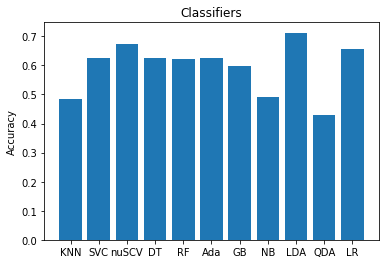

In [26]:
import matplotlib.pyplot as plt
classifier=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR']
y_pos = np.arange(len(classifier))
plt.bar(y_pos,np.array(accuracy))
plt.xticks(y_pos, classifier)
plt.ylabel('Accuracy')
plt.title('Classifiers')

# Principle Component Analysis

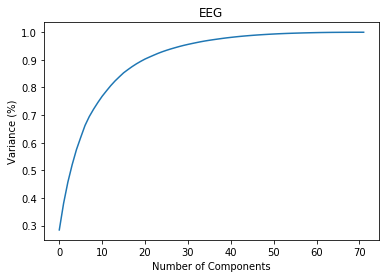

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('EEG')
plt.show()

In [0]:
clf = SVC(kernel='rbf')
pca = PCA(n_components=20)

#pipeline = Pipeline([('selector',pca), ('estimator', clf)])
pipeline = Pipeline([('transformer', scalar),('selector',pca), ('estimator', clf)])


In [29]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_pca=[]
std_pca=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_pca.append(np.array(scores).mean())
    std_pca.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 43.0357%
SVC
****Results****
Accuracy: 60.0000%
NuSVC
****Results****
Accuracy: 58.7500%
DecisionTreeClassifier
****Results****
Accuracy: 55.7143%
RandomForestClassifier
****Results****
Accuracy: 58.5714%
AdaBoostClassifier
****Results****
Accuracy: 58.3929%
GradientBoostingClassifier
****Results****
Accuracy: 59.8214%
GaussianNB
****Results****
Accuracy: 58.3929%
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.5714%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 40.1786%
LogisticRegression
****Results****
Accuracy: 69.8214%


# RFE

In [0]:
from sklearn.feature_selection import RFE


In [0]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf"),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]


In [0]:

clf = SVC(kernel='rbf')
rfe=RFE(SVC(kernel='linear'),n_features_to_select=25,step=10,verbose=0)   

#pipeline = Pipeline([('selector',rfe), ('estimator', clf)])
pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [33]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_rfe=[]
std_rfe=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_rfe.append(np.array(scores).mean())
    std_rfe.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 61.4286%
SVC
****Results****
Accuracy: 64.4643%
NuSVC
****Results****
Accuracy: 63.0357%
DecisionTreeClassifier
****Results****
Accuracy: 62.8571%
RandomForestClassifier
****Results****
Accuracy: 65.7143%
AdaBoostClassifier
****Results****
Accuracy: 57.5000%
GradientBoostingClassifier
****Results****
Accuracy: 64.4643%
GaussianNB
****Results****
Accuracy: 60.3571%
LinearDiscriminantAnalysis
****Results****
Accuracy: 61.6071%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 61.2500%
LogisticRegression
****Results****
Accuracy: 65.8929%


## Fine Tuned RFE

In [46]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="rbf")
n_features = [10,15,20,25,30]
step=[5,7,9,10]
Cs = [ 1,2,3,5,7,10,15,30,50,70,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('rfe', rfe), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(rfe__step=step,rfe__n_features_to_select=n_features,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

KeyboardInterrupt: ignored

In [0]:

pipe = Pipeline(steps=[('scaler',scalar),('kbest', SelectKBest(f_classif, k=10)), 
                       ('classifier', SVC(kernel="rbf",C=3,gamma=0.01))])
scores = cross_val_score(pipe, X, y, cv = 5)
print('average accuracy : ',np.array(scores).mean(),np.std(np.array(scores)))

# SKbest

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [0]:

clf = SVC(kernel='rbf')
skbest=SelectKBest(f_classif, k=100)
#pipeline = Pipeline([('selector',skbest), ('estimator', clf)])
pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [45]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_kbest=[]
std_kbest=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_kbest.append(np.array(scores).mean())
    std_kbest.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 61.4286%
SVC
****Results****
Accuracy: 64.4643%
NuSVC
****Results****
Accuracy: 63.0357%
DecisionTreeClassifier
****Results****
Accuracy: 61.6071%
RandomForestClassifier
****Results****
Accuracy: 61.4286%
AdaBoostClassifier
****Results****
Accuracy: 57.5000%
GradientBoostingClassifier
****Results****
Accuracy: 64.6429%
GaussianNB
****Results****
Accuracy: 60.3571%
LinearDiscriminantAnalysis
****Results****
Accuracy: 61.6071%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 61.2500%
LogisticRegression
****Results****
Accuracy: 65.8929%


## SKBEST tuning 

### SVM

In [47]:
from sklearn.model_selection import GridSearchCV
skbest=SelectKBest(f_classif, k=100)
clf = SVC(kernel="rbf")
k=[10,20,30,50,70,100]
Cs = [ 1,2,3,5,7,10,15,30,50,60,70,80,100]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler',scalar),('kbest', skbest), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(kbest__k=k,
                              classifier__C=Cs,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

{'classifier__C': 80, 'classifier__gamma': 0.001, 'kbest__k': 70}

In [48]:

pipe = Pipeline(steps=[('scaler',scalar),('kbest', SelectKBest(f_classif, k=70)), 
                       ('classifier', SVC(kernel="rbf",C=80,gamma=0.001))])
scores = cross_val_score(pipe, X, y, cv = 5)
print('average accuracy : ',np.array(scores).mean(),np.std(np.array(scores)))

average accuracy :  0.6964285714285715 0.03571428571428572


### NUSVM

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
skbest=SelectKBest(f_classif, k=70)
clf = NuSVC(kernel="rbf")
k=[10,20,30,50,70,100]
nu = [ 0.01, 0.1,0.3,0.4,0.5,0.6,0.7]
gammas = [0.001,0.01,0.02,0.03,0.04,0.05,0.1,0.3,0.5,0.8,1]
pipe = Pipeline(steps=[('scaler',scalar),('kbest', skbest), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(kbest__k=k,
                              classifier__nu=nu,classifier__gamma=gammas),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

{'classifier__gamma': 0.01, 'classifier__nu': 0.6, 'kbest__k': 100}

In [51]:

pipe = Pipeline(steps=[('scaler',scalar),('kbest', SelectKBest(f_classif, k=100)), 
                       ('classifier', NuSVC(kernel="rbf",nu=0.6,gamma=0.01))])
scores = cross_val_score(pipe, X, y, cv = 5)
print('average accuracy : ',np.array(scores).mean(),np.std(np.array(scores)))

average accuracy :  0.6839285714285714 0.07567721464434675


### LR

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
skbest=SelectKBest(f_classif, k=100)
clf = LogisticRegression()
k=[10,20,30,50,70,90,120,140]
C= [0.1, 1,3,5,8, 10,12,15,18,20]
penalty=["l1","l2"]
pipe = Pipeline(steps=[('scaler',scalar),('kbest', skbest), ('classifier', clf)])
estimator = GridSearchCV(pipe,
                         dict(kbest__k=k,
                              classifier__C=C,classifier__penalty=penalty),cv=5,n_jobs=-1,iid=False) 

results = estimator.fit(X,y)
results.best_params_

{'classifier__C': 15, 'classifier__penalty': 'l2', 'kbest__k': 120}

In [56]:

pipe = Pipeline(steps=[('scaler',scalar),('kbest', SelectKBest(f_classif, k=120)), 
                       ('classifier', LogisticRegression(C=15,penalty='l2'))])
scores = cross_val_score(pipe, X, y, cv = 5)
print('average accuracy : ',np.array(scores).mean(),np.std(np.array(scores)))

average accuracy :  0.6839285714285713 0.11785714285714284


# VarianceThreshold

In [0]:
from sklearn.feature_selection import VarianceThreshold
clf = SVC(kernel='rbf')
algo=selector = VarianceThreshold()
#pipeline = Pipeline([('selector',algo), ('estimator', clf)])
pipeline = Pipeline([('transformer', scalar),('selector',rfe), ('estimator', clf)])


In [38]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy_var=[]
std_var=[]
f1_scores=[]
f1_scores_std=[]
for clfs in classifiers:
    pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    
    print("="*30)
    print(name)       
    print('****Results****')
    scores = cross_val_score(pipeline, X, y, cv=5)
    #f1_score = cross_val_score(clf, X_rfe, y, cv=5,scoring='f1')
    print("Accuracy: {:.4%}".format(np.array(scores).mean()))
    accuracy_var.append(np.array(scores).mean())
    std_var.append(np.array(scores).std())
    #f1_scores.append(np.array(f1_score).mean())
    #f1_scores_std.append(np.array(f1_score).std())


KNeighborsClassifier
****Results****
Accuracy: 61.4286%
SVC
****Results****
Accuracy: 64.4643%
NuSVC
****Results****
Accuracy: 63.0357%
DecisionTreeClassifier
****Results****
Accuracy: 57.1429%
RandomForestClassifier
****Results****
Accuracy: 65.7143%
AdaBoostClassifier
****Results****
Accuracy: 57.5000%
GradientBoostingClassifier
****Results****
Accuracy: 64.4643%
GaussianNB
****Results****
Accuracy: 60.3571%
LinearDiscriminantAnalysis
****Results****
Accuracy: 61.6071%
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 61.2500%
LogisticRegression
****Results****
Accuracy: 65.8929%


In [39]:
len(accuracy),len(accuracy_pca),len(accuracy_rfe),len(accuracy_kbest),len(accuracy_var)

(11, 11, 11, 11, 11)

In [0]:
result=pd.DataFrame([accuracy,accuracy_pca,accuracy_rfe,accuracy_kbest,accuracy_var],
                    index=['Accuracy','PCA',"RFE",'kbest','VAR'],
                    columns=['KNN','SVC','nuSCV','DT','RF','Ada','GB','NB','LDA','QDA','LR'])

In [41]:
result.T

,Accuracy,PCA,RFE,kbest,VAR
KNN,0.485714,0.430357,0.614286,0.614286,0.614286
SVC,0.626786,0.600000,0.644643,0.644643,0.644643
nuSCV,0.673214,0.587500,0.630357,0.630357,0.630357
DT,0.626786,0.557143,0.628571,0.642857,0.571429
RF,0.623214,0.585714,0.657143,0.642857,0.657143
Ada,0.625000,0.583929,0.575000,0.575000,0.575000
GB,0.598214,0.598214,0.644643,0.673214,0.644643
NB,0.492857,0.583929,0.603571,0.603571,0.603571
LDA,0.712500,0.685714,0.616071,0.616071,0.616071
QDA,0.430357,0.401786,0.612500,0.612500,0.612500
